In [52]:
import os
import numpy as np
from torch.utils.data import DataLoader
import pandas as pd
from sklearn import metrics
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
from sklearn.cluster import DBSCAN
from sklearn.metrics.cluster import adjusted_rand_score
import matplotlib.pyplot as plt
import seaborn as sns
import urllib.request
import skimage as sk
from natsort import natsorted, ns
from skimage import io
import time
from torchvision import datasets, transforms

## Dataset Download

In [168]:
for i, url in enumerate(dataset['URL']):
    # find html tag img from frame name MAIN
    html = urllib.request.urlopen(url).read()
    html = str(html)
    frame_tag = html.split('MAIN')
    img_tag = frame_tag[0].split('img src="')
    # find image from img_tag list starts with exactly '/detail'
    for tag in img_tag:
        if tag.startswith('/detail'):
            if tag.startswith('/detail_s'):
                continue
            img_url = tag.split('"')[0]
            print(img_url)
            # download image from img_url
            urllib.request.urlretrieve('https://www.wga.hu' + img_url, 'image_input/' + str(i) + '.jpg')
            time.sleep(1)
            break
        else:
            continue


ValueError: unknown url type: '0.jpg'

# Dataset Loading From https://www.wga.hu/

In [169]:
dataset = pd.read_csv('dataset.csv')
# select form = painting and url
dataset = dataset[dataset['FORM'] == 'painting']
dataset = dataset[dataset['URL'].notnull()]
# download image from url, save into image_input
dataset

AUTHOR                              BORN-DIED   
6     ALENZA Y NIETO, Leonardo     (b. 1807, Madrid, d. 1845, Madrid)  \
7     ALENZA Y NIETO, Leonardo     (b. 1807, Madrid, d. 1845, Madrid)   
119             BLAKE, William     (b. 1757, London, d. 1827, London)   
120             BLAKE, William     (b. 1757, London, d. 1827, London)   
124            BÖCKLIN, Arnold     (b. 1827, Basel, d. 1901, Firenze)   
...                        ...                                    ...   
1322       VELDE, Henry van de  (b. 1863, Antwerpen, d. 1957, Zürich)   
1323       VELDE, Henry van de  (b. 1863, Antwerpen, d. 1957, Zürich)   
1324       VELDE, Henry van de  (b. 1863, Antwerpen, d. 1957, Zürich)   
1376             WALLIS, Henry    (b. 1830, London, d. 1916, Croydon)   
1377             WALLIS, Henry    (b. 1830, London, d. 1916, Croydon)   

                                                TITLE     DATE   
6                          Satire on Romantic Suicide  c. 1839  \
7                                    Triumph of David     1842   
119                                              Pity  c. 1795   
120                                              Pity  c. 1795   
124   Castle by the Sea (Murder in the Castle Garden)     1859   
...                                               ...      ...   
1322                     Bathing Huts at Blankenberge     1888   
1323                 Abstract composition with plants  1892-93   
1324                              Woman at the Window     1889   
1376                              Death of Chatterton     1856   
1377                                 The Stonebreaker  1857-58   

                                              TECHNIQUE   
6                             Oil on canvas, 35 x 26 cm  \
7                                         Oil on canvas   
119   Colour print finished in ink and watercolour, ...   
120   Relief etching, printed in colour and finished...   
124                         Oil on canvas, 112 x 177 cm   
...                                                 ...   
1322                         Oil on canvas, 71 x 100 cm   
1323                        Pastel on paper, 48 x 51 cm   
1324                        Oil on canvas, 111 x 125 cm   
1376                          Oil on canvas, 62 x 93 cm   
1377                          Oil on canvas, 65 x 79 cm   

                                               LOCATION   
6                               Museo Romántico, Madrid  \
7     Museo de la Real Academia de San Fernando, Madrid   
119                                Tate Gallery, London   
120                Metropolitan Museum of Art, New York   
124                              Museum Folkwang, Essen   
...                                                 ...   
1322                                  Kunsthaus, Zurich   
1323                     Kröller-Müller Museum, Otterlo   
1324     Koninklijk Museum voor Schone Kunsten, Antwerp   
1376                               Tate Britain, London   
1377      Birmingham Museum and Art Gallery, Birmingham   

                                                 URL      FORM        TYPE   
6      https://www.wga.hu/html/a/alenza/satire1.html  painting       genre  \
7      https://www.wga.hu/html/a/alenza/triumph.html  painting   religious   
119     https://www.wga.hu/html/b/blake/041pity.html  painting       other   
120     https://www.wga.hu/html/b/blake/042pity.html  painting       other   
124    https://www.wga.hu/html/b/bocklin/castle.html  painting   landscape   
...                                              ...       ...         ...   
1322  https://www.wga.hu/html/v/velde3/5bathhut.html  painting   landscape   
1323   https://www.wga.hu/html/v/velde3/5plants.html  painting       other   
1324  https://www.wga.hu/html/v/velde3/5woman_w.html  painting       genre   
1376  https://www.wga.hu/html/w/wallis/chattert.html  painting  historical   
1377  https://www.wga.hu/html/w/wallis/stonebre.html  painting       genre   


## Dataset Preprocessing

In [147]:
dataset = dataset[dataset['URL'].notnull()]
#drop all columns except for artist and title
# dataset = dataset.drop(columns=['FORM', 'URL', 'DATE', 'TECHNIQUE', 'LOCATION', 'style', 'genre', 'school', 'timeframe', 'subject', 'type', 'school'])
#drop BORN-DIED, DATE, TECHNIQUE, LOCATION, URL, FORM, TYPE, SCHOOL,
dataset = dataset.drop(columns=['BORN-DIED', 'DATE', 'TECHNIQUE', 'LOCATION', 'URL', 'FORM', 'TYPE', 'SCHOOL'])
dataset

AUTHOR   
6     ALENZA Y NIETO, Leonardo  \
7     ALENZA Y NIETO, Leonardo   
119             BLAKE, William   
120             BLAKE, William   
124            BÖCKLIN, Arnold   
...                        ...   
1322       VELDE, Henry van de   
1323       VELDE, Henry van de   
1324       VELDE, Henry van de   
1376             WALLIS, Henry   
1377             WALLIS, Henry   

                                                TITLE  TIMEFRAME  
6                          Satire on Romantic Suicide  1801-1850  
7                                    Triumph of David  1801-1850  
119                                              Pity  1751-1800  
120                                              Pity  1751-1800  
124   Castle by the Sea (Murder in the Castle Garden)  1851-1900  
...                                               ...        ...  
1322                     Bathing Huts at Blankenberge  1851-1900  
1323                 Abstract composition with plants  1851-1900  
1324                              Woman at the Window  1851-1900  
1376                              Death of Chatterton  1851-1900  
1377                                 The Stonebreaker  1851-1900  

[336 rows x 3 columns]

In [170]:
# load images from image_input, make array using numpy
list_files = os.listdir('./image_input/training')
list_files = natsorted(list_files, alg=ns.IGNORECASE)
image_list = []
for filename in list_files:
    image = np.array(io.imread('./image_input/training/' + filename))
    resized_image = sk.transform.resize(image, (200, 200, 3))
    image_list.append(resized_image)
image_list = np.array(image_list)
# attach list_files as URL to dataset
dataset['URL'] = list_files
# reset index
dataset = dataset.reset_index(drop=True)
dataset

AUTHOR                              BORN-DIED   
0    ALENZA Y NIETO, Leonardo     (b. 1807, Madrid, d. 1845, Madrid)  \
1    ALENZA Y NIETO, Leonardo     (b. 1807, Madrid, d. 1845, Madrid)   
2              BLAKE, William     (b. 1757, London, d. 1827, London)   
3              BLAKE, William     (b. 1757, London, d. 1827, London)   
4             BÖCKLIN, Arnold     (b. 1827, Basel, d. 1901, Firenze)   
..                        ...                                    ...   
331       VELDE, Henry van de  (b. 1863, Antwerpen, d. 1957, Zürich)   
332       VELDE, Henry van de  (b. 1863, Antwerpen, d. 1957, Zürich)   
333       VELDE, Henry van de  (b. 1863, Antwerpen, d. 1957, Zürich)   
334             WALLIS, Henry    (b. 1830, London, d. 1916, Croydon)   
335             WALLIS, Henry    (b. 1830, London, d. 1916, Croydon)   

                                               TITLE     DATE   
0                         Satire on Romantic Suicide  c. 1839  \
1                                   Triumph of David     1842   
2                                               Pity  c. 1795   
3                                               Pity  c. 1795   
4    Castle by the Sea (Murder in the Castle Garden)     1859   
..                                               ...      ...   
331                     Bathing Huts at Blankenberge     1888   
332                 Abstract composition with plants  1892-93   
333                              Woman at the Window     1889   
334                              Death of Chatterton     1856   
335                                 The Stonebreaker  1857-58   

                                             TECHNIQUE   
0                            Oil on canvas, 35 x 26 cm  \
1                                        Oil on canvas   
2    Colour print finished in ink and watercolour, ...   
3    Relief etching, printed in colour and finished...   
4                          Oil on canvas, 112 x 177 cm   
..                                                 ...   
331                         Oil on canvas, 71 x 100 cm   
332                        Pastel on paper, 48 x 51 cm   
333                        Oil on canvas, 111 x 125 cm   
334                          Oil on canvas, 62 x 93 cm   
335                          Oil on canvas, 65 x 79 cm   

                                              LOCATION      URL      FORM   
0                              Museo Romántico, Madrid    0.jpg  painting  \
1    Museo de la Real Academia de San Fernando, Madrid    1.jpg  painting   
2                                 Tate Gallery, London    2.jpg  painting   
3                 Metropolitan Museum of Art, New York    3.jpg  painting   
4                               Museum Folkwang, Essen    4.jpg  painting   
..                                                 ...      ...       ...   
331                                  Kunsthaus, Zurich  331.jpg  painting   
332                     Kröller-Müller Museum, Otterlo  332.jpg  painting   
333     Koninklijk Museum voor Schone Kunsten, Antwerp  333.jpg  painting   
334                               Tate Britain, London  334.jpg  painting   
335      Birmingham Museum and Art Gallery, Birmingham  335.jpg  painting   

           TYPE   SCHOOL  TIMEFRAME  
0         genre  Spanish  1801-1850  
1     religious  Spanish  1801-1850  
2         other  English  1751-1800  
3         other  English  1751-1800  
4     landscape    Swiss  1851-1900  
..          ...      ...        ...  
331   landscape  Belgian  1851-1900  
332       other  Belgian  1851-1900  
333       genre  Belgian  1851-1900  
334  historical  English  1851-1900  
335       genre  English  1851-1900  

[336 rows x 11 columns]

## Feature Selection

In [182]:
# select training from tensor rgb_images to numpy
rgb_images = image_list
gray_images = []
for image in rgb_images:
    gray_image = sk.color.rgb2gray(image)
    gray_images.append(gray_image)
gray_images = np.array(gray_images)

canny_edges = []
for image in gray_images:
    canny_edge = sk.feature.canny(image, sigma=1)
    canny_edges.append(canny_edge)
canny_edges = np.array(canny_edges)

canny_gradients = []
for image in gray_images:
    canny_gradient = sk.filters.sobel(image)
    canny_gradients.append(canny_gradient)
canny_gradients = np.array(canny_gradients)

color_gradient = []
for image in rgb_images:
    color_gradient.append(sk.filters.sobel(image))
color_gradient = np.array(color_gradient)

hsv_images = []
for image in rgb_images:
    hsv_image = sk.color.rgb2hsv(image)
    hsv_images.append(hsv_image)
hsv_images = np.array(hsv_images)

color_histogram = []
for image in rgb_images:
    color_histogram.append(sk.exposure.histogram(image, nbins=256))
color_histogram = np.array(color_histogram)

hsv_histogram = []
for image in hsv_images:
    hsv_histogram.append(sk.exposure.histogram(image, nbins=256))
hsv_histogram = np.array(hsv_histogram)





/home/whbaek/programming/DataSpell/DataspellProjects/lib/python3.11/site-packages/skimage/_shared/utils.py:316: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel, or set channel_axis.
  return func(*args, **kwargs)


In [183]:
#  features
rgb_images = rgb_images.reshape((rgb_images.shape[0], -1))
gray_images = gray_images.reshape((gray_images.shape[0], -1))
canny_edges = canny_edges.reshape((canny_edges.shape[0], -1))
canny_gradients = canny_gradients.reshape((canny_gradients.shape[0], -1))
hsv_images = hsv_images.reshape((hsv_images.shape[0], -1))
color_histogram = color_histogram.reshape((color_histogram.shape[0], -1))
hsv_histogram = hsv_histogram.reshape((hsv_histogram.shape[0], -1))
color_gradient = color_gradient.reshape((color_gradient.shape[0], -1))

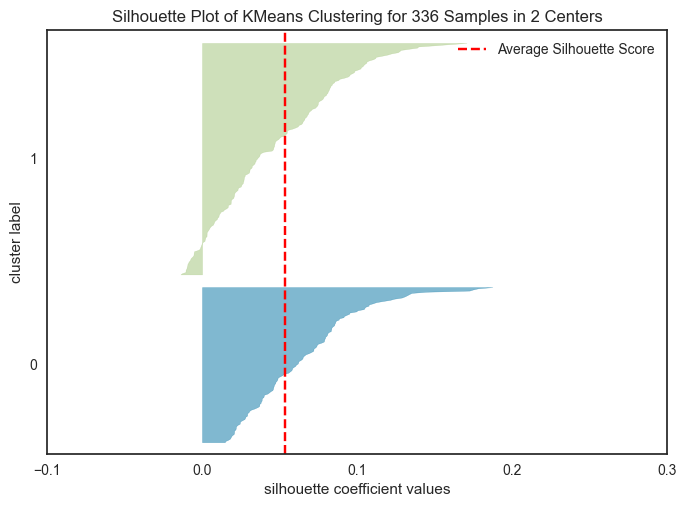

k: 2 score: 0.05338593499749995


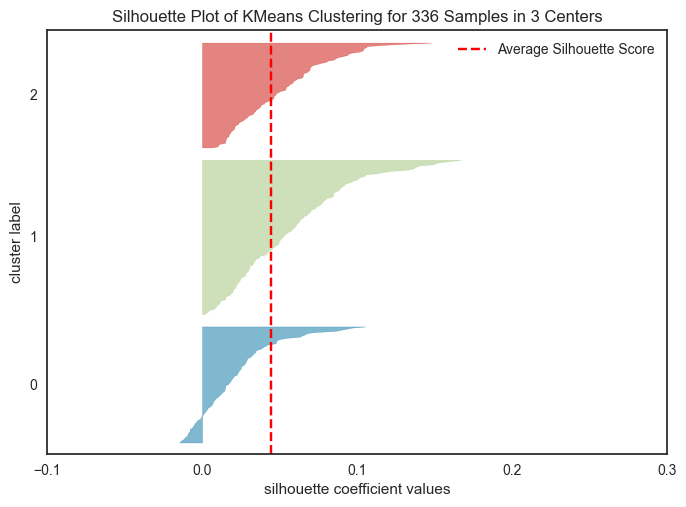

k: 3 score: 0.04447590880462733


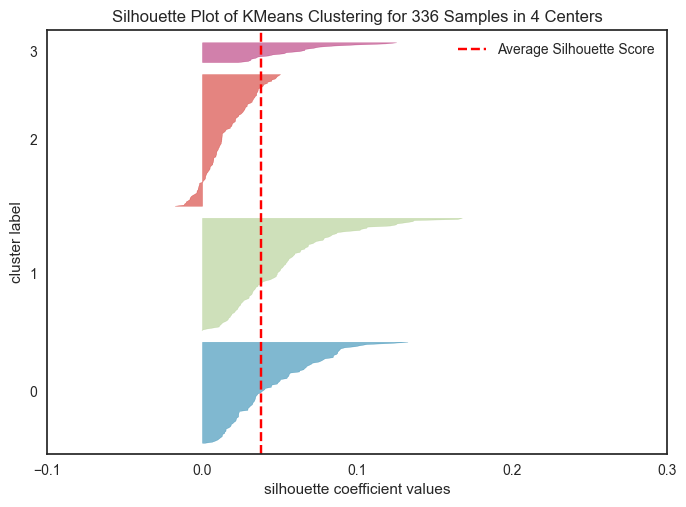

k: 4 score: 0.03776410166954106


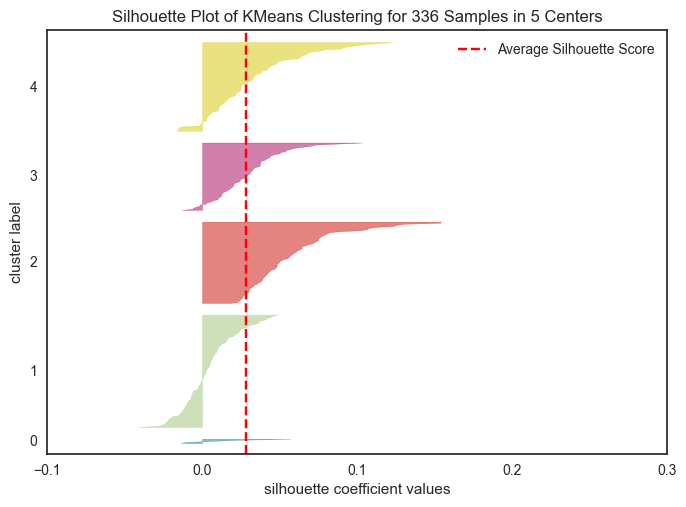

k: 5 score: 0.028223589374238973


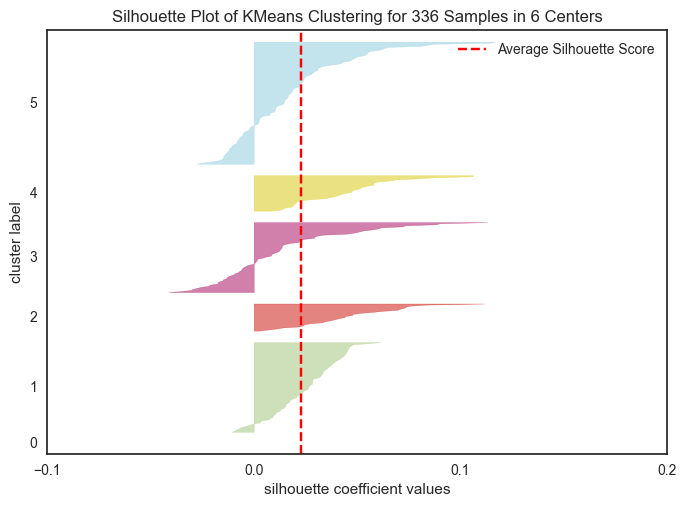

k: 6 score: 0.0228452682404096


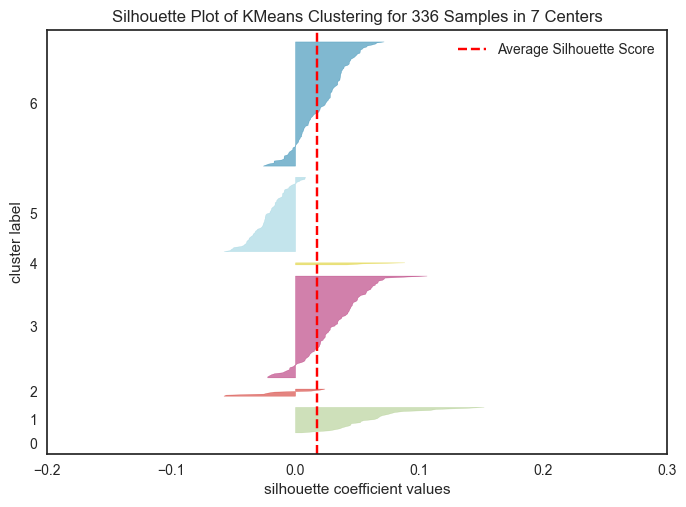

k: 7 score: 0.017450239100014177


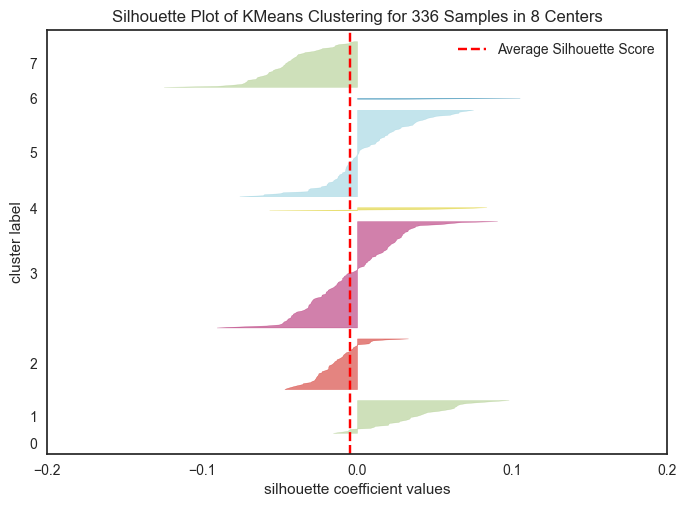

k: 8 score: -0.004491798260447903


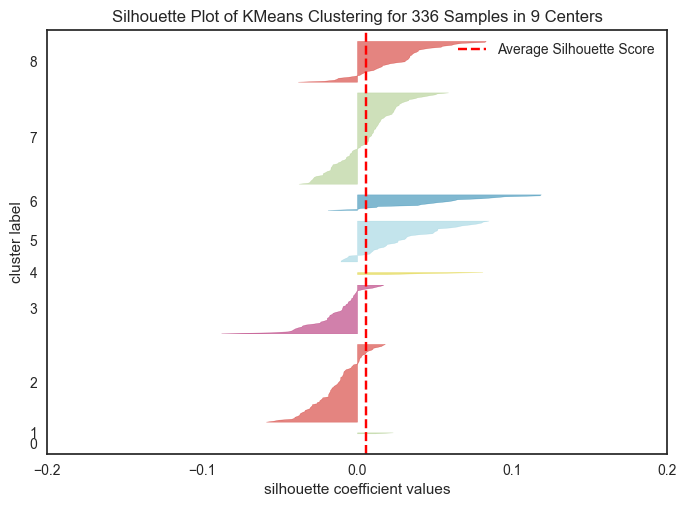

k: 9 score: 0.005909795022380555


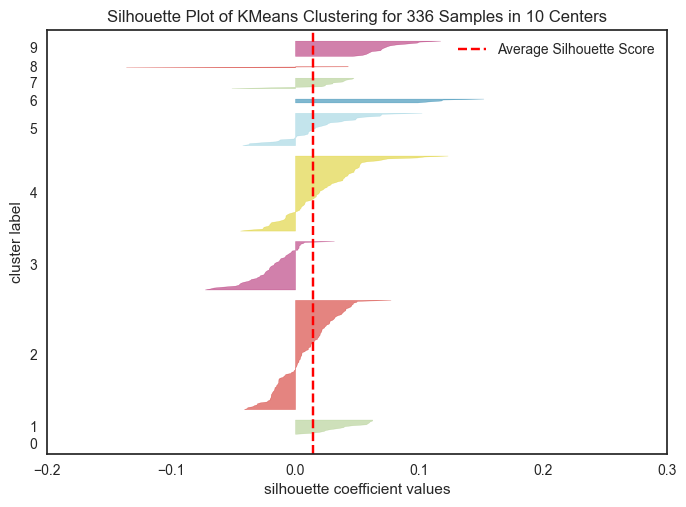

k: 10 score: 0.014099713048252159
Lowest silhouette score: -0.004491798260447903 at K: 8


In [184]:
# kmeans using all features

features = np.hstack((hsv_images, gray_images, canny_gradients, color_gradient))

# find k using silhouette score
from sklearn.metrics import silhouette_score
from yellowbrick.cluster import SilhouetteVisualizer

silhouette_scores = []
for k in range(2, 11):
    kmeans = KMeans(n_clusters=k, n_init="auto", init="k-means++")
    kmeans.fit(features)
    score = silhouette_score(features, kmeans.labels_)
    silhouette_scores.append(score)
    visualizer = SilhouetteVisualizer(kmeans, colors='yellowbrick')
    visualizer.fit(features)
    visualizer.show()
    print("k:", k, "score:", score)

print("Lowest silhouette score:", min(silhouette_scores), "at K:", (silhouette_scores.index(min(silhouette_scores)) + 2))

In [193]:
k = 6
kmeans = []
labels = []
centroids = []
silhouette_scores = []
for i in range(0, 10):
    tmp_kmeans = KMeans(n_clusters=k, n_init="auto", init="k-means++")
    tmp_kmeans.fit(features)
    tmp_labels = tmp_kmeans.labels_
    tmp_centroids = tmp_kmeans.cluster_centers_
    kmeans.append(tmp_kmeans)
    labels.append(tmp_labels)
    centroids.append(tmp_centroids)
    score = silhouette_score(features, tmp_labels)
    silhouette_scores.append(score)

# find best kmeans using silhouette score
min_score = min(silhouette_scores)
best_kmeans = None
best_labels = None
best_centroids = None
for i in range(0, 10):
    if silhouette_scores[i] == min_score:
        best_kmeans = kmeans[i]
        best_labels = labels[i]
        best_centroids = centroids[i]
        best_score = silhouette_scores[i]
        best_index = i

kmeans = best_kmeans
labels = best_labels
centroids = best_centroids

#concat labels to original dataset
dataset['LABEL'] = labels
dataset

AUTHOR                              BORN-DIED   
0    ALENZA Y NIETO, Leonardo     (b. 1807, Madrid, d. 1845, Madrid)  \
1    ALENZA Y NIETO, Leonardo     (b. 1807, Madrid, d. 1845, Madrid)   
2              BLAKE, William     (b. 1757, London, d. 1827, London)   
3              BLAKE, William     (b. 1757, London, d. 1827, London)   
4             BÖCKLIN, Arnold     (b. 1827, Basel, d. 1901, Firenze)   
..                        ...                                    ...   
331       VELDE, Henry van de  (b. 1863, Antwerpen, d. 1957, Zürich)   
332       VELDE, Henry van de  (b. 1863, Antwerpen, d. 1957, Zürich)   
333       VELDE, Henry van de  (b. 1863, Antwerpen, d. 1957, Zürich)   
334             WALLIS, Henry    (b. 1830, London, d. 1916, Croydon)   
335             WALLIS, Henry    (b. 1830, London, d. 1916, Croydon)   

                                               TITLE     DATE   
0                         Satire on Romantic Suicide  c. 1839  \
1                                   Triumph of David     1842   
2                                               Pity  c. 1795   
3                                               Pity  c. 1795   
4    Castle by the Sea (Murder in the Castle Garden)     1859   
..                                               ...      ...   
331                     Bathing Huts at Blankenberge     1888   
332                 Abstract composition with plants  1892-93   
333                              Woman at the Window     1889   
334                              Death of Chatterton     1856   
335                                 The Stonebreaker  1857-58   

                                             TECHNIQUE   
0                            Oil on canvas, 35 x 26 cm  \
1                                        Oil on canvas   
2    Colour print finished in ink and watercolour, ...   
3    Relief etching, printed in colour and finished...   
4                          Oil on canvas, 112 x 177 cm   
..                                                 ...   
331                         Oil on canvas, 71 x 100 cm   
332                        Pastel on paper, 48 x 51 cm   
333                        Oil on canvas, 111 x 125 cm   
334                          Oil on canvas, 62 x 93 cm   
335                          Oil on canvas, 65 x 79 cm   

                                              LOCATION      URL      FORM   
0                              Museo Romántico, Madrid    0.jpg  painting  \
1    Museo de la Real Academia de San Fernando, Madrid    1.jpg  painting   
2                                 Tate Gallery, London    2.jpg  painting   
3                 Metropolitan Museum of Art, New York    3.jpg  painting   
4                               Museum Folkwang, Essen    4.jpg  painting   
..                                                 ...      ...       ...   
331                                  Kunsthaus, Zurich  331.jpg  painting   
332                     Kröller-Müller Museum, Otterlo  332.jpg  painting   
333     Koninklijk Museum voor Schone Kunsten, Antwerp  333.jpg  painting   
334                               Tate Britain, London  334.jpg  painting   
335      Birmingham Museum and Art Gallery, Birmingham  335.jpg  painting   

           TYPE   SCHOOL  TIMEFRAME  LABEL  
0         genre  Spanish  1801-1850      5  
1     religious  Spanish  1801-1850      5  
2         other  English  1751-1800      2  
3         other  English  1751-1800      2  
4     landscape    Swiss  1851-1900      2  
..          ...      ...        ...    ...  
331   landscape  Belgian  1851-1900      1  
332       other  Belgian  1851-1900      4  
333       genre  Belgian  1851-1900      2  
334  historical  English  1851-1900      5  
335       genre  English  1851-1900      4  

[336 rows x 12 columns]

## Print Clusters

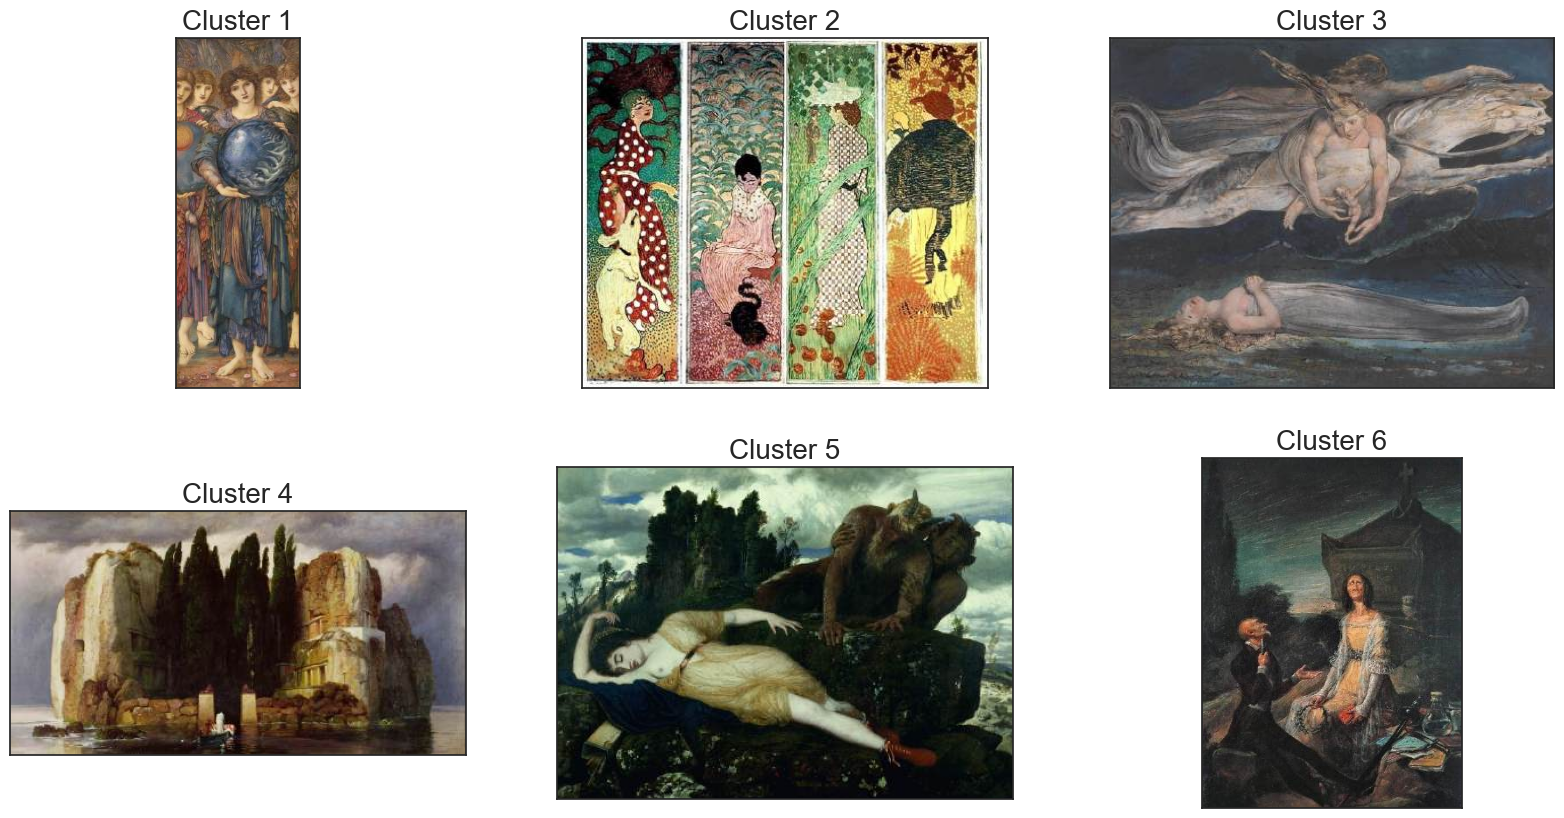

In [194]:
# plot clusters
fig, ax = plt.subplots(2, 3, figsize=(20, 10))
centers = kmeans.cluster_centers_

#find center's index
center_index = []
for i in range(0, k):
    center_index.append(np.where(labels == i)[0][0])

#plot images
for i in range(0, k):
    ax[i // 3, i % 3].imshow(sk.io.imread('./image_input/training/' + dataset['URL'][center_index[i]]))
    ax[i // 3, i % 3].set_title("Cluster " + str(i + 1), fontsize=20)
    ax[i // 3, i % 3].set_xticks([])
    ax[i // 3, i % 3].set_yticks([])

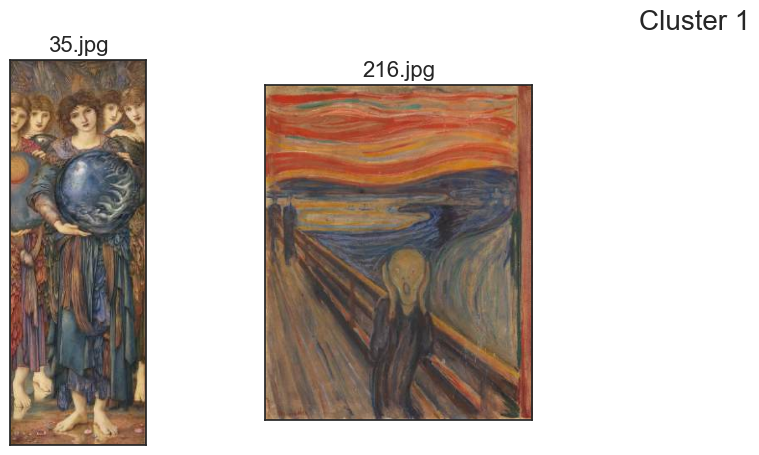

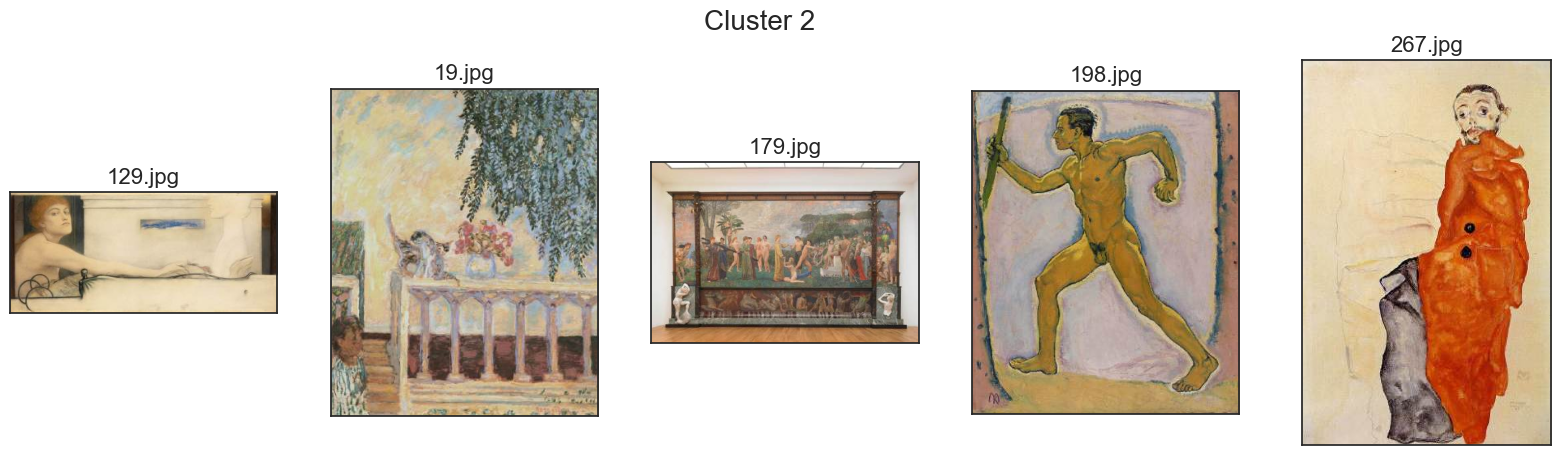

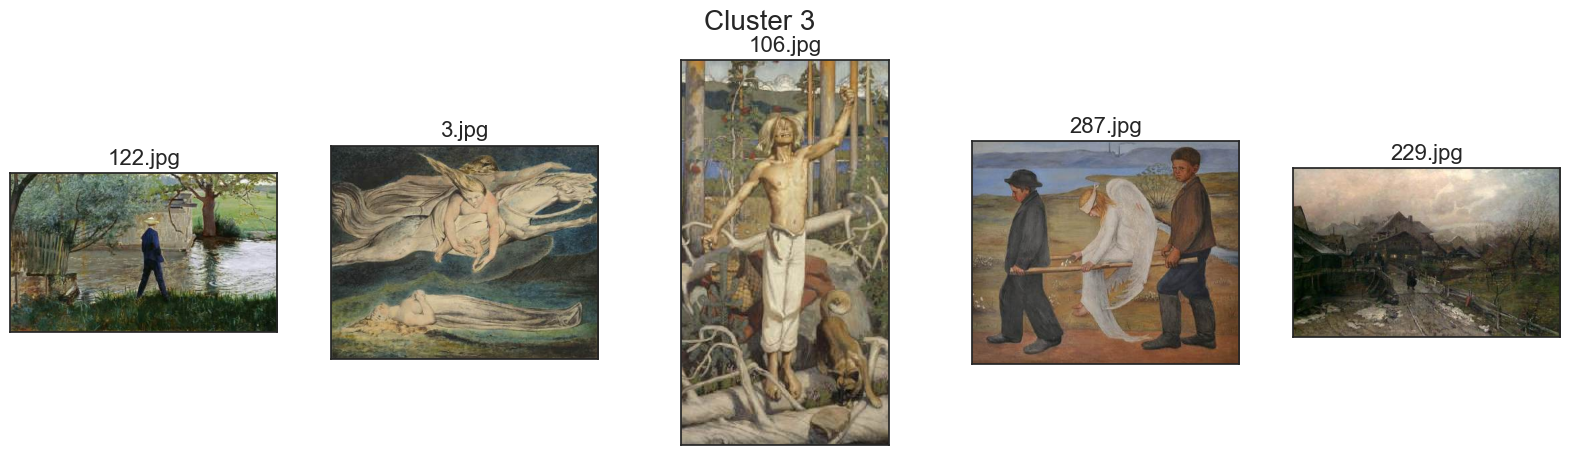

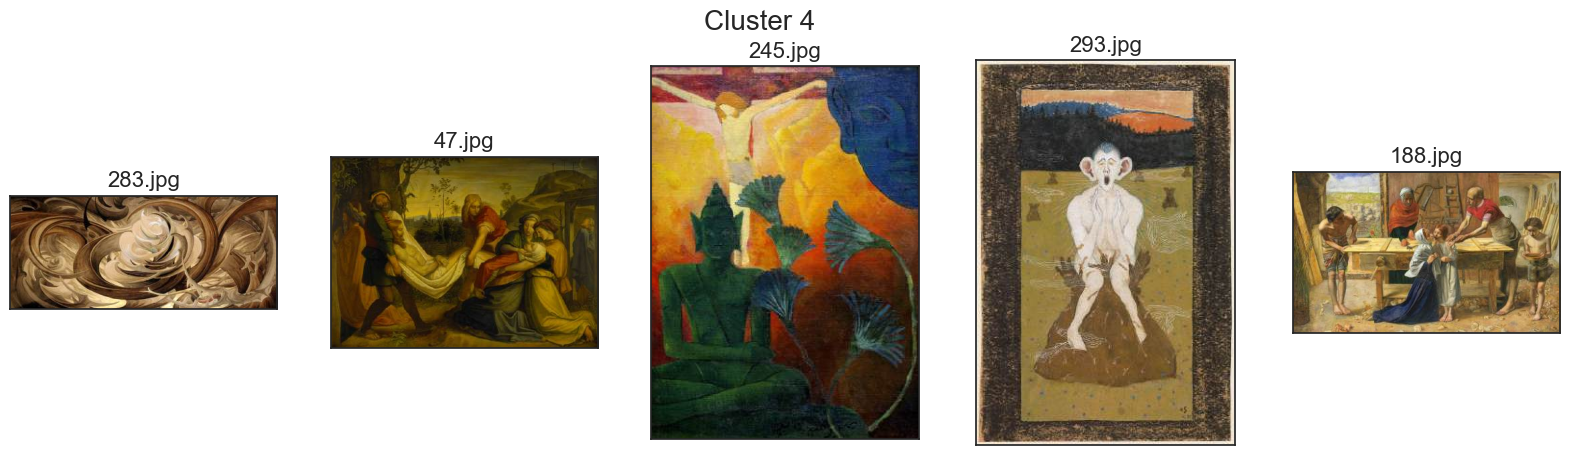

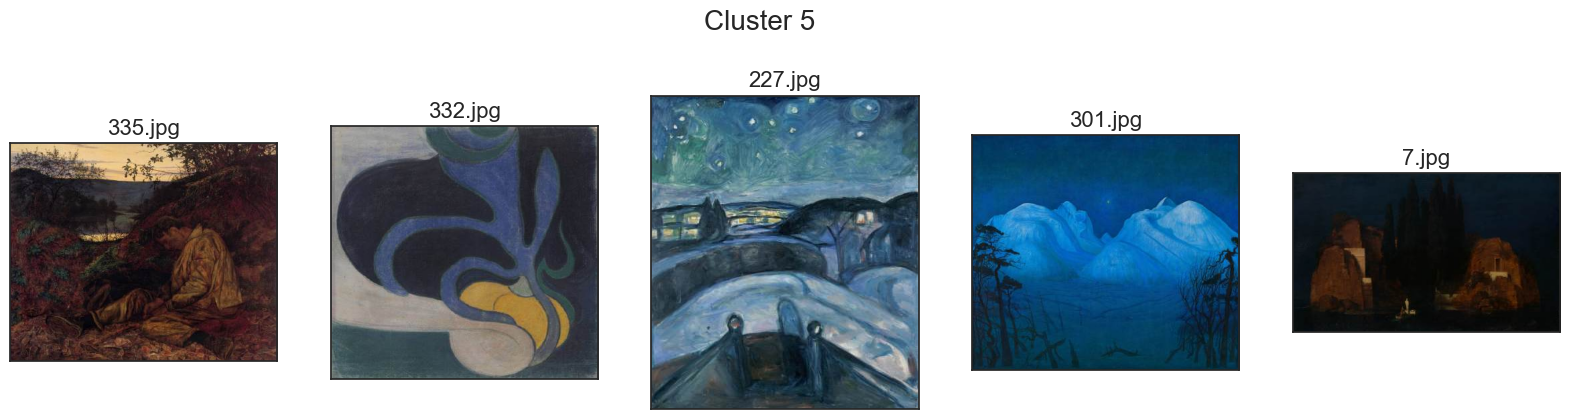

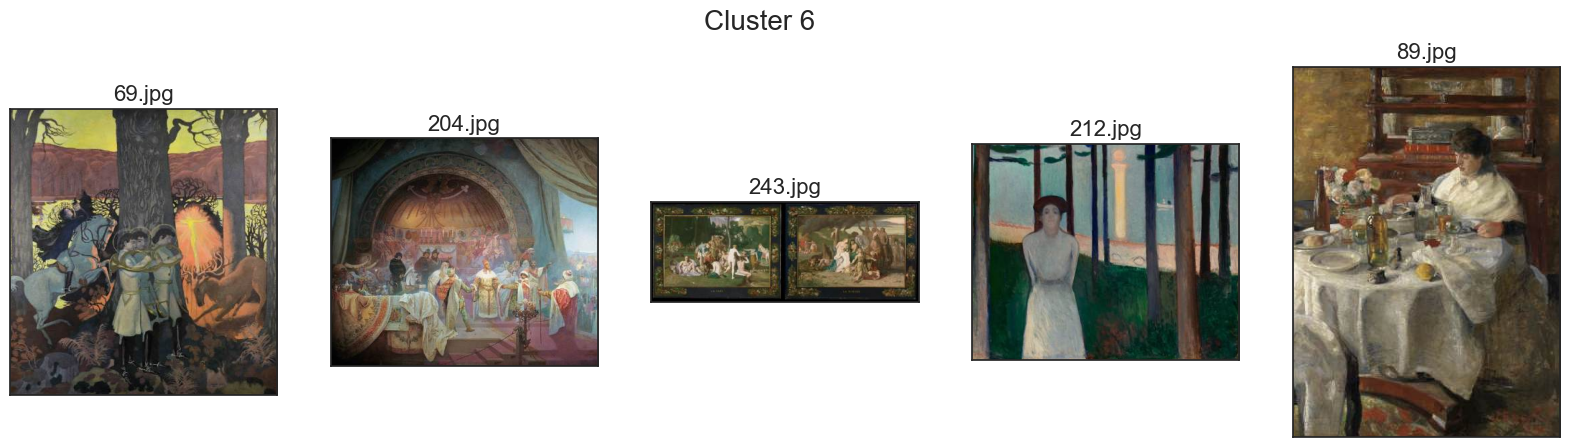

In [197]:
# plot 5 random images from each cluster
for i in range(0, k):
    sns.set_style("white")
    plt.figure(figsize=(20, 5))
    plt.suptitle("Cluster " + str(i + 1), fontsize=20)
    try:
        chosen_image = dataset[dataset['LABEL'] == i].sample(5)
    except:
        chosen_image = dataset[dataset['LABEL'] == i].sample(2)
    chosen_image_url_list = chosen_image['URL'].values
    for (j, chosen_url) in enumerate(chosen_image_url_list):
        plt.subplot(1, 5, j + 1)
        plt.imshow(sk.io.imread('./image_input/training/' + chosen_url))
        plt.title(chosen_url, fontsize=16)
        plt.xticks([])
        plt.yticks([])
    plt.xticks([])
    plt.yticks([])

    plt.show()

In [ ]:
print(adjusted_rand_score(labels, gray_labels))

/usr/local/lib/python3.10/dist-packages/sklearn/utils/_array_api.py:185: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  array = numpy.asarray(array, order=order, dtype=dtype)


AttributeError: ignored

/usr/local/lib/python3.10/dist-packages/sklearn/utils/_array_api.py:185: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  array = numpy.asarray(array, order=order, dtype=dtype)


AttributeError: ignored

In [ ]:
k = 10

gray_kmeans = KMeans(n_clusters=k, n_init="auto", init="k-means++")
gray_kmeans.fit(gray_images)
predict = gray_kmeans.fit_predict()

gray_labels = gray_kmeans.labels_
centroids = gray_kmeans.cluster_centers_

print("클러스터링 결과:")

print(centroids)

print(adjusted_rand_score(labels, predict))

ValueError: ignored

In [ ]:
test_images = np.vstack(test_images)
test_labels = np.concatenate(test_labels)

X_ = pd.DataFrame(data=test_images)
y_ = pd.Series(data=test_labels)

print("데이터 정보", testset_drawing)

pca = PCA(n_components=500)
test_PCA = pca.fit_transform(X_)

test_PCA = pd.DataFrame(data=test_PCA)
testDF = pd.DataFrame(data=test_PCA.loc[:, 0:1], index=test_PCA.index)
testDF = pd.concat((testDF, y_), axis=1, join="inner")
testDF.columns = ["x-axis", "y-axis", "Label"]
sns.lmplot(x="x-axis", y="y-axis", hue="Label", data=testDF, fit_reg=False, height=8)
plt.grid()

In [ ]:
n_components = 2
learning_rate = 300
perplexity = 30
early_exaggeration = 12
init = 'random'

tSNE = TSNE(n_components=n_components, learning_rate=learning_rate,
            perplexity=perplexity, early_exaggeration=early_exaggeration, init=init)

epsNum = 1.0
minSamples = 9

In [ ]:
X_test_tSNE = tSNE.fit_transform(test_PCA.loc[:, :])
X_test_tSNE = pd.DataFrame(data=X_test_tSNE)
testDF = pd.DataFrame(data=X_test_tSNE.loc[:, :], index=test_PCA.index)
testDF = pd.concat((testDF, y_), axis=1, join="inner")
testDF.columns = ["x-axis", "y-axis", "Label"]

model = DBSCAN(eps=epsNum, min_samples=minSamples)

model.fit(testDF)
predict = model.fit_predict(testDF)

dimension10 = adjusted_rand_score(testDF["Label"], predict)
print(dimension10)

testDF["Label"] = predict
sns.lmplot(x="x-axis", y="y-axis", hue="Label", data=testDF, fit_reg=False, height=8)
plt.title("Clustering Result")
plt.grid()

In [ ]:
n_components = 2
learning_rate = 300
perplexity = 30
early_exaggeration = 12
init = 'random'

tSNE = TSNE(n_components=n_components, learning_rate=learning_rate,
            perplexity=perplexity, early_exaggeration=early_exaggeration, init=init)

In [ ]:
X_test_tSNE = tSNE.fit_transform(test_PCA.loc[:, :])
X_test_tSNE = pd.DataFrame(data=X_test_tSNE)
testDF = pd.DataFrame(data=X_test_tSNE.loc[:, :], index=test_PCA.index)
testDF = pd.concat((testDF, y_), axis=1, join="inner")
testDF.columns = ["x-axis", "y-axis", "Label"]

model = KMeans(n_clusters=10, n_init="auto", init="k-means++")
model.fit(testDF)
predict = model.fit_predict(testDF)

dimension10 = adjusted_rand_score(testDF["Label"], predict)

testDF["Label"] = predict
sns.lmplot(x="x-axis", y="y-axis", hue="Label", data=testDF, fit_reg=False, height=8)
plt.title("Clustering Result")
plt.grid()

In [ ]:
centroids = pd.DataFrame(model.cluster_centers_, columns=testDF.columns)
print(centroids)
centroids['cluster'] = ['Cluster {}'.format(i) for i in centroids.index]
print(centroids)



In [ ]:
distances = model.transform(testDF)

closest_cluster_idx = distances.argmin(axis=1)

# 가장 가까운 데이터 확인
closest_data = testDF.iloc[closest_cluster_idx]
print(closest_data)